In [16]:
import MDAnalysis as mda
import MDAnalysis.analysis.hydrogenbonds as hba
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# Define initial variables
universe_file = 'FRAP-rap-rep1_500ns.part0003.gro'
trajectory_file = 'FRAP-rap-rep1_concat500ns_pbc.xtc'
resA = 86
resB = 2042

In [3]:
# Load the universe
u = mda.Universe(universe_file, trajectory_file)

In [4]:
# Define the water bridge analysis
w = hba.WaterBridgeAnalysis(
    universe=u,
    selection1=f'resid {resA}',
    selection2=f'resid {resB}',
    water_selection='resname SOL',
    order=2,  # Order of the water bridge
    forcefield='other',
    donors=('NZ', 'NE', 'NH1', 'NH2', 'O','OH'),  # Donor atoms
    acceptors=('OD1', 'OD2', 'O','OH')  # Acceptor atoms
)

In [5]:
# Run the analysis
w.run()

In [6]:
# CUSTOM ANALYSIS FUNCTION: function to classify and count types of water bridges.
def analysis(current, output, u):
    # Decompose the first hydrogen bond
    sele1_index, sele1_heavy_index, atom2, heavy_atom2, dist, angle = current[0]
    # Decompose the last hydrogen bond
    atom1, heavy_atom1, sele2_index, sele2_heavy_index, dist, angle = current[-1]
    # Expand the atom index to the resname, resid, atom names
    sele1 = u.atoms[sele1_index]
    sele2 = u.atoms[sele2_index]
    (s1_resname, s1_resid, s1_name) = (sele1.resname, sele1.resid, sele1.name)
    (s2_resname, s2_resid, s2_name) = (sele2.resname, sele2.resid, sele2.name)
    # If the residue name is ARG and the atom name is one of the hydrogen atoms, change it to HH
    if s2_resname == 'ARG' and s2_name in ('HH12', 'HH11', 'HH22', 'HH21'):
        s2_name = 'HH'
    # Set up the key which defines this type of water bridge
    key = (s1_resname, s1_resid, s1_name, s2_resname, s2_resid, s2_name)
    # Increment the number of this type of water bridge by 1
    output[key] += 1

In [7]:
# Count water bridges by type
new = w.count_by_type(analysis_func=analysis)

In [8]:
# Prepare data for saving
modified_data = [((t[0], t[2], t[3], t[5]), v) for (t, v) in new]
df = pd.DataFrame(modified_data, columns=['tuple', 'value'])
df[['Res1', 'Atom1', 'Res2', 'Atom2']] = pd.DataFrame(df['tuple'].tolist(), index=df.index)
df = df.drop(['tuple'], axis=1)
df['Inhibitor'] = 1  # You can replace this with a variable if needed

In [9]:
# Display the DataFrame
print(df)

      value Res1 Atom1 Res2 Atom2  Inhibitor
0  0.774345  GLY     O  ARG    HH          1
1  0.894682  GLY     O  ARG    HE          1


In [10]:
# Save to CSV
csv_file_path = 'water_bridges_2105_47.csv'
df.to_csv(csv_file_path, index=False)

In [12]:
# Count water bridges by time
count_by_time_data = w.count_by_time()

In [13]:
# Unpack the data into two lists: times and counts
times, counts = zip(*count_by_time_data)

In [14]:
# Convert times from picoseconds to nanoseconds
times_in_ns = [time / 1000 for time in times]

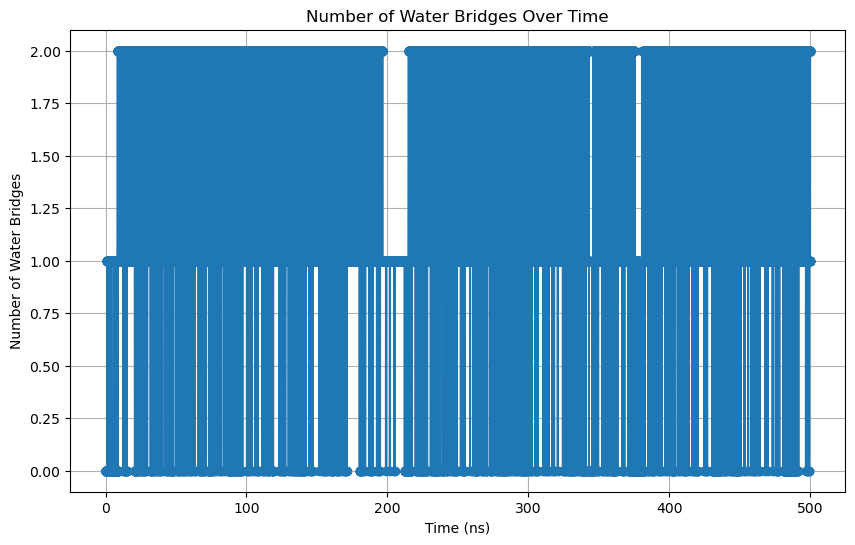

In [19]:
# PLOTTING DATA: Representation of water bridges over time
plt.figure(figsize=(10, 6))
plt.plot(times_in_ns, counts, marker='o', linestyle='-')
plt.xlabel('Time (ns)')
plt.ylabel('Number of Water Bridges')
plt.title('Number of Water Bridges Over Time')
plt.grid(True)
plt.show()